<a href="https://colab.research.google.com/github/DanieleAngioni97/CV_Project/blob/main/Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Preparation**

In [14]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

MAIN_PATH = "/content/drive/My Drive/Colab_Notebooks/CV_Project"

df_train = pd.read_csv(MAIN_PATH + "/training_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_train = df_train[['filename','x', 'y', 'u', 'v']]

df_validation = pd.read_csv(MAIN_PATH + "/validation_list.csv", names=['filename', 'x', 'y', 'u', 'v', 'room'])
df_validation = df_validation[['filename','x', 'y', 'u', 'v']]

IMG_SIZE = 128
BATCH_SIZE = 64

train_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
train_dataset = train_dataset.flow_from_dataframe(
    dataframe = df_train,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = ['x', 'y', 'u', 'v'],
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "raw")

validation_dataset = ImageDataGenerator(rescale = 1./255) #map data in the range 0-1
validation_dataset = validation_dataset.flow_from_dataframe(
    dataframe = df_validation,
    directory = MAIN_PATH + "/images",
    x_col = "filename",
    y_col = ['x', 'y', 'u', 'v'],
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = "raw")

    # x_col = df_train['filename'],
    # y_col = df_train[['x', 'y', 'u', 'v']],

Found 10259 validated image filenames.
Found 3101 validated image filenames.


# **Visualizing some images**

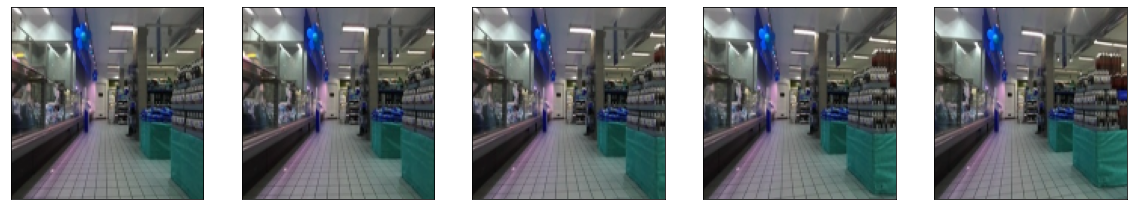

In [37]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow #used because cv2.imshow get crushed in colab

N_IMAGES = 5    #images to be visualized
bias = 300      #starting index from the test set for the visualization

train = df_train.to_numpy()
files_train = train[:,0]

x_train = np.zeros((N_IMAGES, IMG_SIZE, IMG_SIZE, 3))

for i,file_name in enumerate(files_train[bias:N_IMAGES + bias]):
    img = cv2.imread(MAIN_PATH + "/images/" + file_name)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    x_train[i,:,:,:] = img/255
  
  
plt.figure(figsize=(20, 10))
for i in range(N_IMAGES):
    ax = plt.subplot(2, N_IMAGES, i+1)
    plt.imshow(x_train[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# **Training the model**

CARICAMENTO DATASET

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

flow_from_dataframe mi permette di usare direttamente il csv per costruire i dataloaders

Tutorial
https://www.youtube.com/watch?v=uqomO_BZ44g&ab_channel=WhenMathsmeetscoding

https://www.youtube.com/watch?v=_L2uYfVV48I&ab_channel=deeplizard